## Import libraries

In [1]:
import os
import glob
import copy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.dates import DateFormatter
import numpy as np
from datetime import datetime, timezone
import pandas as pd

import h5py
import xarray as xr
import netCDF4 as nc

years = range(2014, 2025)

<!DOCTYPE html>
<html>
<h2>Values of entries in the MASIE HDF5 data matrix</h2>
<h3>Classifications:</h3>
<ul>
    <li>0 (outside Northern Hemisphere)</li>
    <li>1 (open water)</li>
    <li>2 (land without snow)</li>
    <li>3 (sea or lake ice)</li>
    <li>4 (snow covered land)</li>
</ul>
</html>

In [2]:
def convertHDF2NPY(root_dir, save_dir, sie_index_name):
    pos_min = -0.25e07
    pos_max = 0.25e07
    output_list = []
    for yr in years:
        print(f"Processing {yr}")
        hdf_dir = os.path.join(root_dir, str(yr))
        npy_dir = os.path.join(save_dir, str(yr))
        os.makedirs(npy_dir, exist_ok=True)

        for hdf5_file in glob.glob(os.path.join(hdf_dir, "*4km*.nc")):
            # Open dataset
            ds = xr.open_dataset(hdf5_file)

            # Get date
            dt64 = ds["time"][0].values
            formatted_date = np.datetime_as_string(dt64, unit="D")

            # Get values
            if sie_index_name == "sea_ice_extent":
                sie = np.array(ds.sel(x=slice(pos_min, pos_max)).sea_ice_extent)
            else:
                sie = np.array(
                    ds.sel(
                        x=slice(pos_min, pos_max), y=slice(pos_min, pos_max)
                    ).IMS_Surface_Values
                )

            # Close dataset
            ds.close()

            # Set all all non-3 values to 0
            sie[sie != 3] = 0

            # Set all 3 values to 1
            sie[sie == 3] = 1

            non_sea_ice_counts = np.count_nonzero(sie == 0)
            sea_ice_counts = np.count_nonzero(sie == 1)

            output_list.append([formatted_date, sea_ice_counts, non_sea_ice_counts])

            npy_file_name = os.path.join(npy_dir, formatted_date)
    #             np.save(npy_file_name, sie)

    df = pd.DataFrame(
        data=output_list, columns=["Date", "Sea-ice Count", "Non-sea-ice Count"]
    )
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    display(df)

    df.to_csv(f"{root_dir}/sea_ice_counts.csv", index=False)

    return df

In [3]:
%%time
df = convertHDF2NPY("D:/IceDyno/netcdf", "D:/IceDyno/netcdf_npy", "sea_ice_extent")

Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021
Processing 2022
Processing 2023
Processing 2024


,Date,Sea-ice Count,Non-sea-ice Count,Year
0,2014-01-01,731635,6948365,2014
1,2014-01-02,738294,6941706,2014
2,2014-01-03,735197,6944803,2014
3,2014-01-04,736775,6943225,2014
4,2014-01-05,737672,6942328,2014
...,...,...,...,...
3704,2024-02-29,753692,6926308,2024
3705,2024-03-01,748947,6931053,2024
3706,2024-03-02,742561,6937439,2024
3707,2024-03-03,747449,6932551,2024


CPU times: total: 5min 11s
Wall time: 7min 44s


In [4]:
def plot_yearly_sie(df):
    fig, axs = plt.subplots(round(len(years) / 2), 2, figsize=(16, 24))
    axs = axs.flatten()

    for i, (year, group) in enumerate(df.groupby("Year")):
        axs[i].plot(
            group["Date"],
            np.log(group["Sea-ice Count"]),
            label=f"Sea-ice Count {year}",
            marker="o",
        )
        axs[i].set_title(f"Sea-ice Counts for {year}", fontsize=18)
        axs[i].set_xlabel("Date", fontsize=16)
        axs[i].set_ylabel("Sea-ice Count (Log)", fontsize=16)
        axs[i].grid(axis="y")

        axs[i].xaxis.set_major_formatter(DateFormatter("%m-%d"))
        axs[i].tick_params(axis="x", rotation=45, labelsize=12)
        axs[i].tick_params(axis="y", labelsize=12)

    axs[-1].remove()
    plt.tight_layout()
    plt.suptitle("Yearly Sea-Ice Coverage 2014-Current", fontsize=22, y=1.025)
    plt.show()

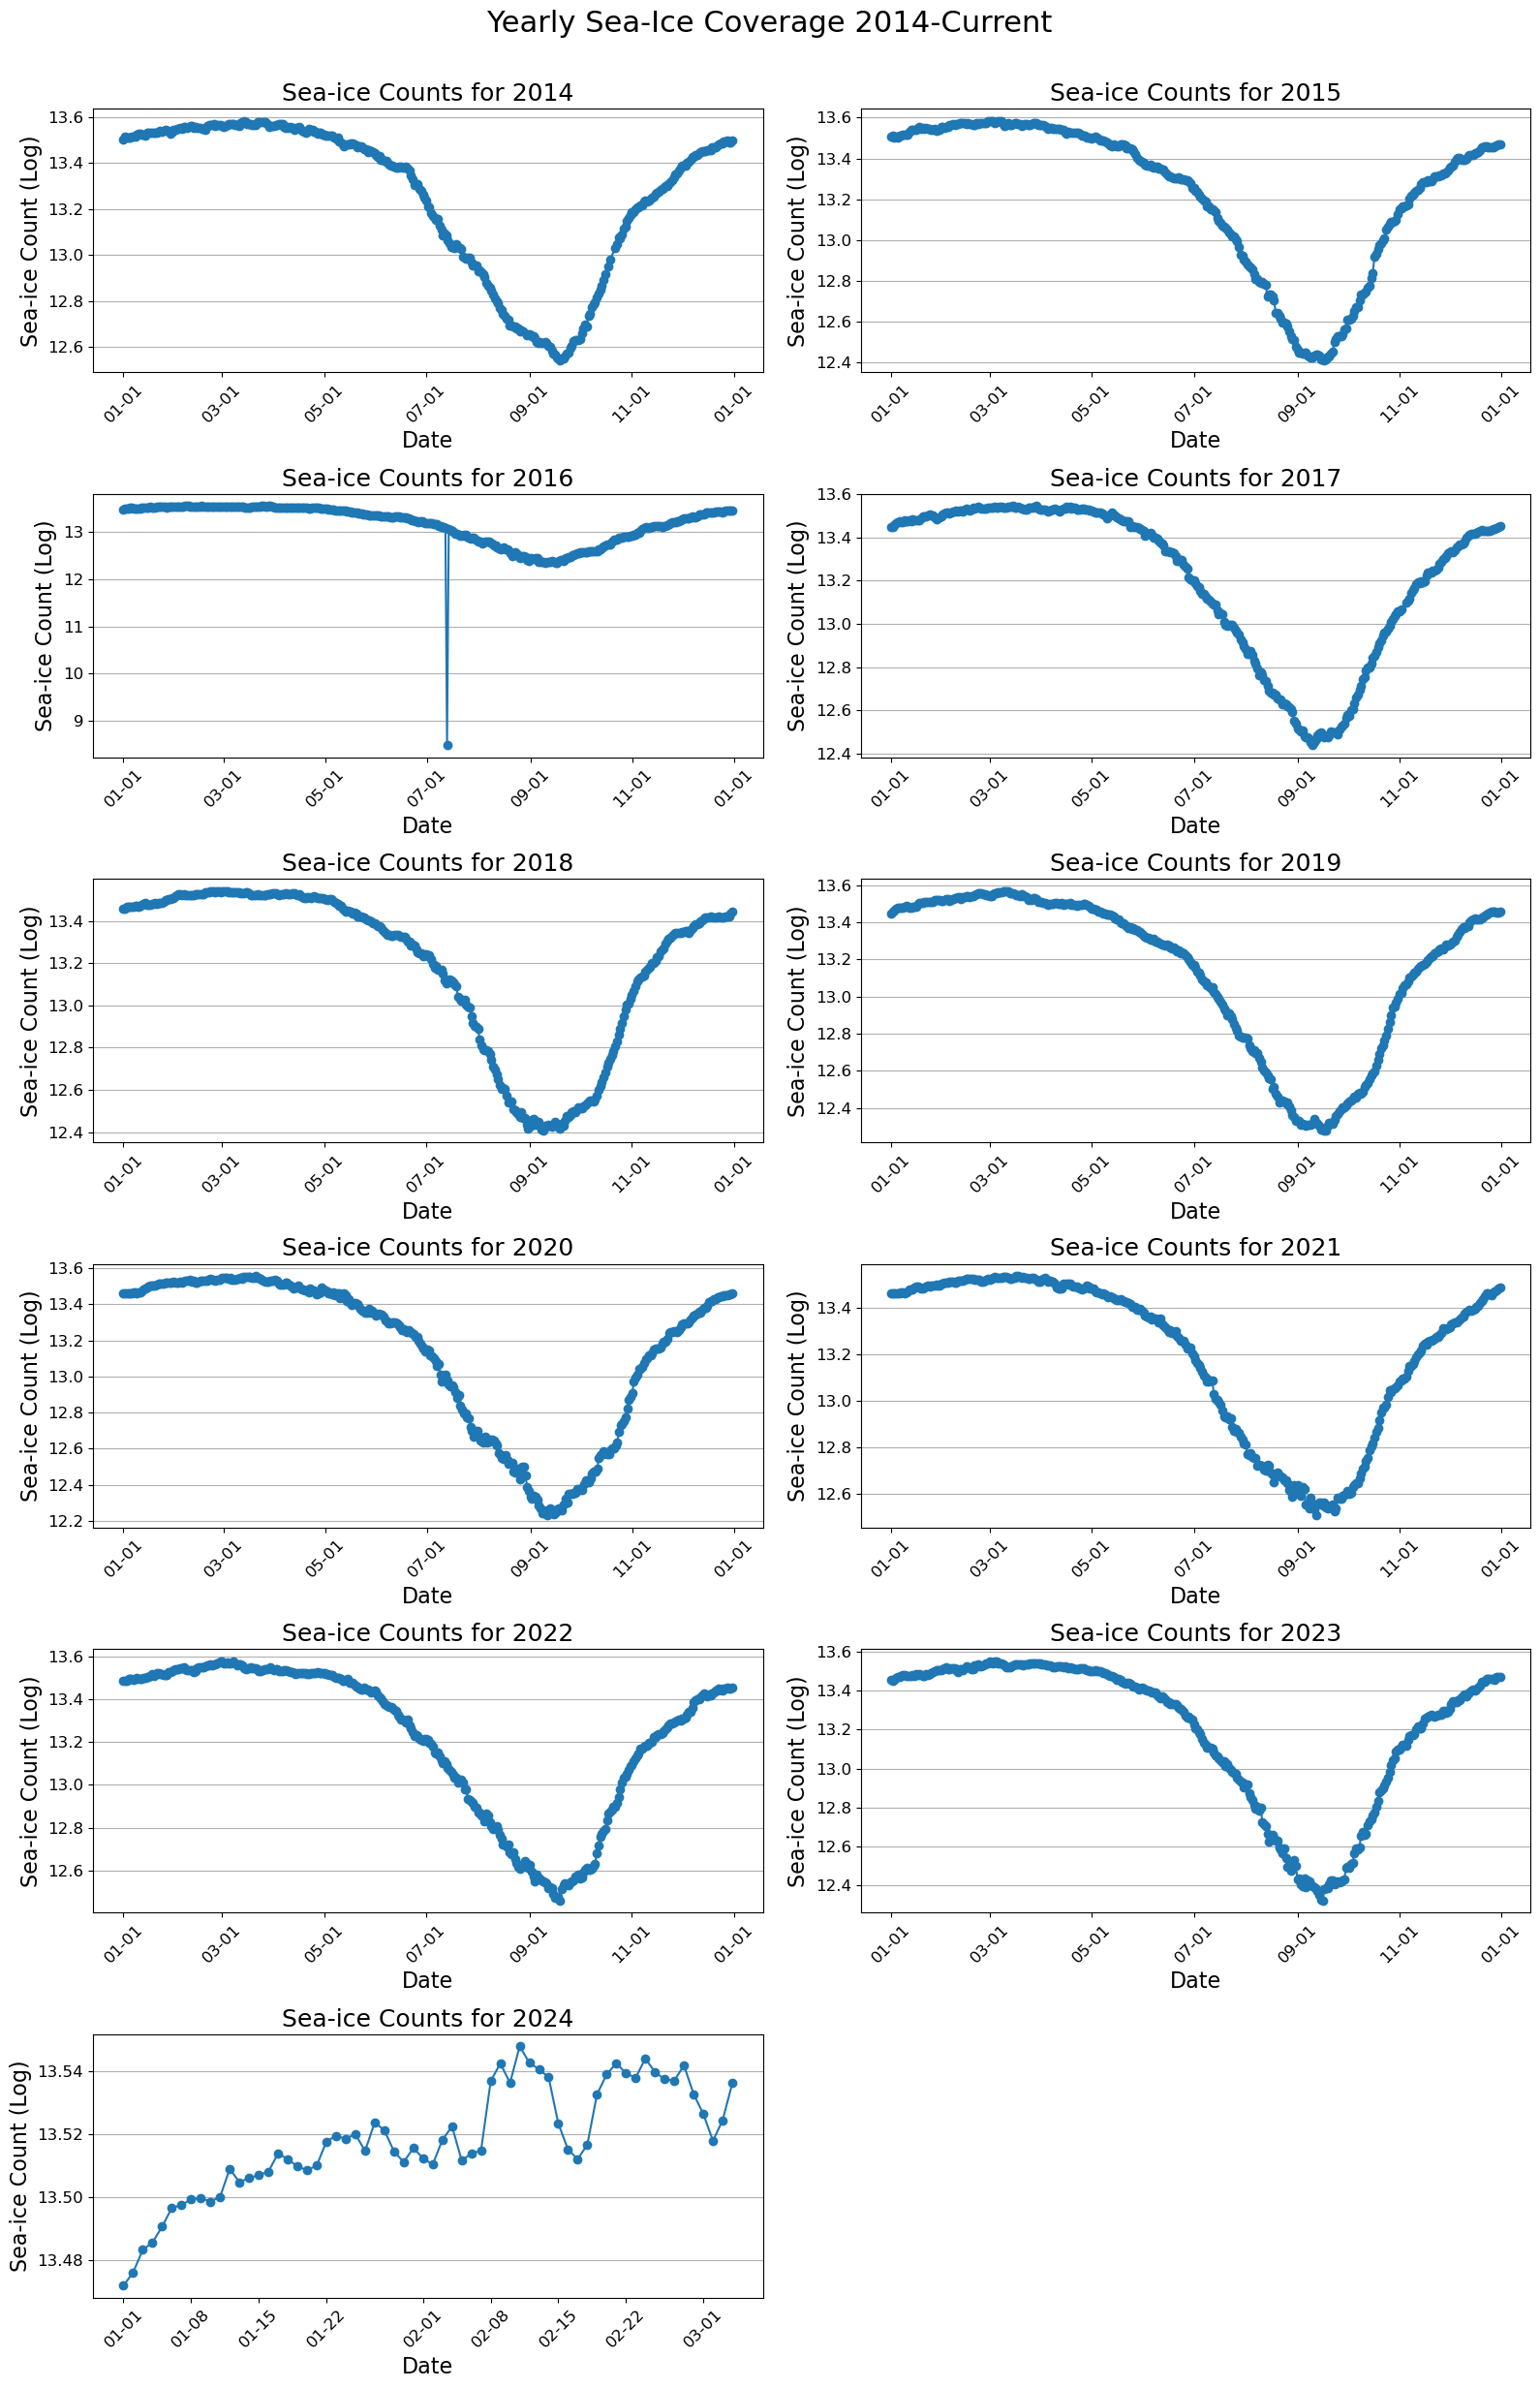

In [5]:
plot_yearly_sie(df)

In [6]:
def plot_yearly_sie_sum(df):
    # Exclude years 2014 and 2024 as they are not completed years
    year_counts = {}
    for yr in years:
        if yr not in [2014, 2024]:
            year_counts[yr] = np.log(np.sum(df[df["Year"] == yr]["Sea-ice Count"]))

    plt.figure(figsize=(10, 6))
    plt.plot(list(year_counts.keys()), list(year_counts.values()), marker="o")
    plt.xlabel("Year")
    plt.ylabel("Yearly Sea-ice Count Log Sum")
    plt.title("Yearly Log Sum of Sea-ice Count")
    plt.grid(True)
    plt.show()

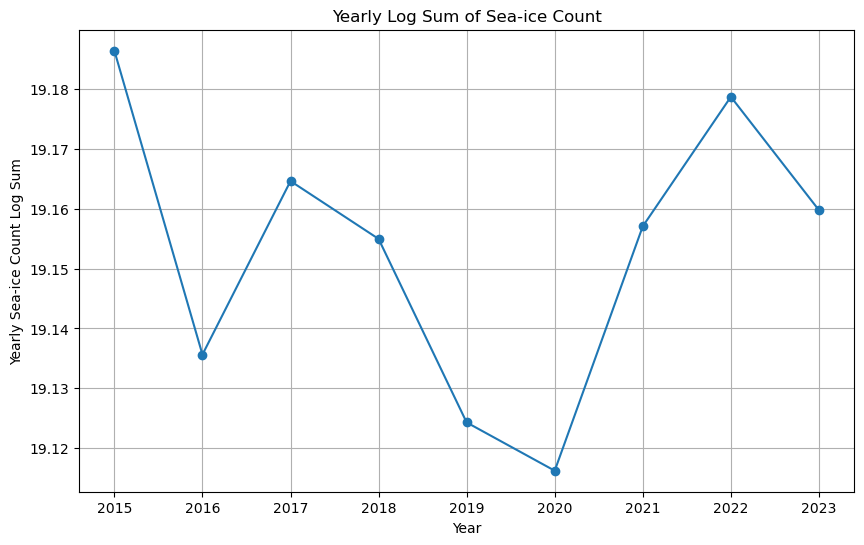

In [7]:
plot_yearly_sie_sum(df)

## IMS HDF5 Values

In [8]:
%%time
df = convertHDF2NPY(
    "D:/IceDyno/IMS_images", "D:/IceDyno/IMS_images_npy", "IMS_Surface_Values"
)

Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021
Processing 2022
Processing 2023
Processing 2024


,Date,Sea-ice Count,Non-sea-ice Count,Year
0,2014-01-01,627378,935122,2014
1,2014-01-02,632413,930087,2014
2,2014-01-03,637108,925392,2014
3,2014-01-04,635182,927318,2014
4,2014-01-05,634939,927561,2014
...,...,...,...,...
3587,2024-02-17,645117,917383,2024
3588,2024-02-18,644546,917954,2024
3589,2024-02-19,647794,914706,2024
3590,2024-02-20,655578,906922,2024


CPU times: total: 56.3 s
Wall time: 1min 48s


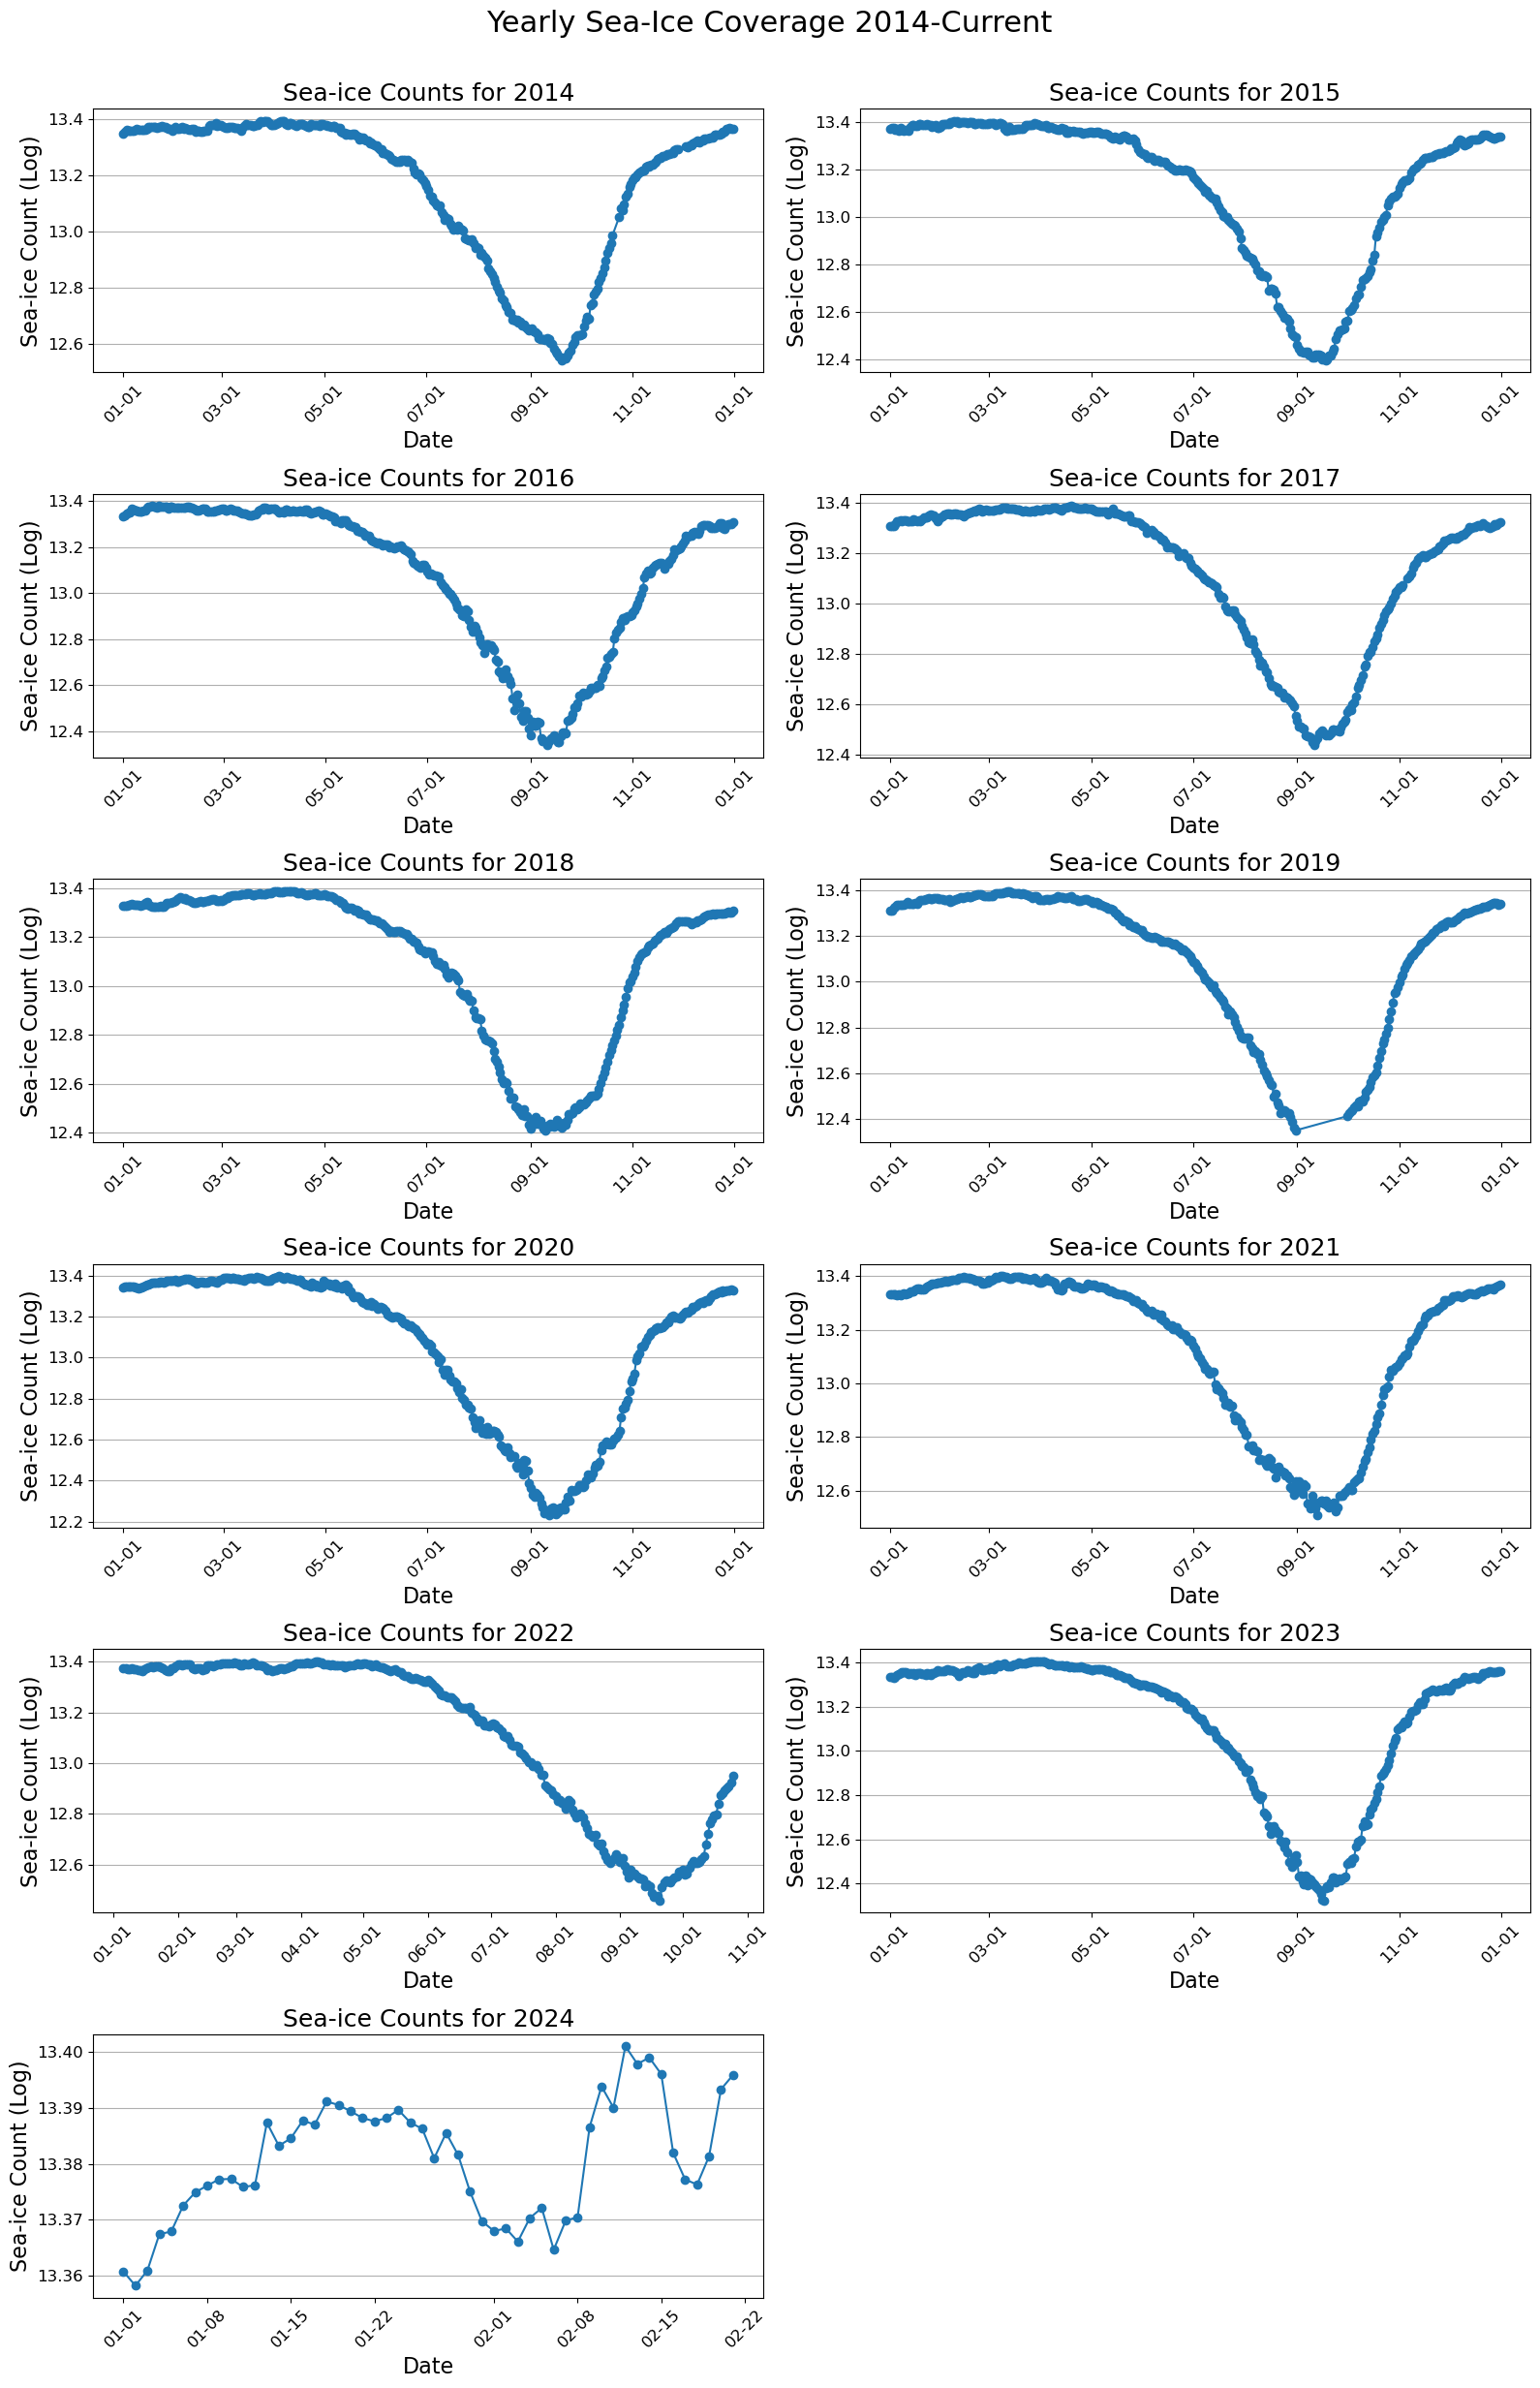

In [9]:
plot_yearly_sie(df)

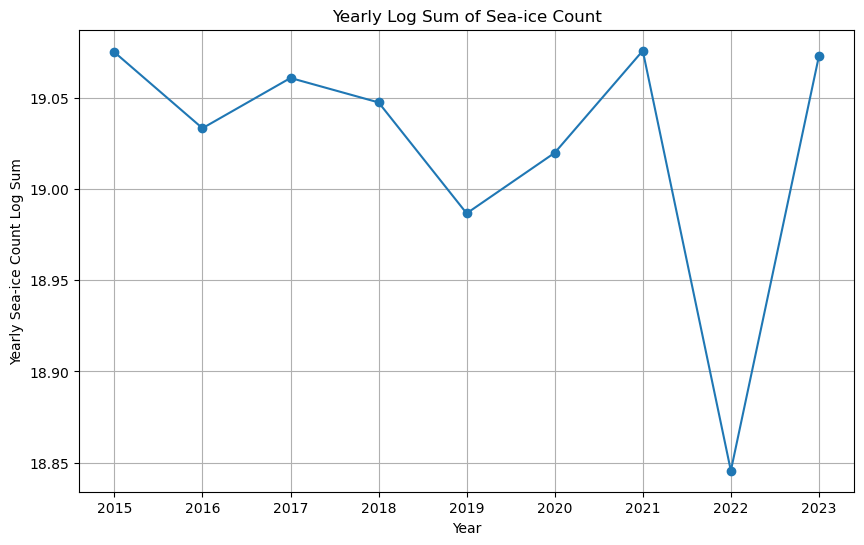

In [10]:
plot_yearly_sie_sum(df)